In [1]:
#loading the data

from pyspark.sql import SQLContext,Row
sqlContext  =SQLContext(sc)
aData = sqlContext.jsonFile("file:///home/cloudera/anurag/meta_Movies_and_TV.json")

/usr/lib/spark/python/pyspark/sql/context.py:478: UserWarning: jsonFile is deprecated. Use read.json() instead.
  warnings.warn("jsonFile is deprecated. Use read.json() instead.")


In [2]:
#delete the unintended column which is creted with the name _corrupt_record and image URL as well, we won't be needing it
aData = aData.drop("_corrupt_record")
aData = aData.drop("imUrl")

In [3]:
aData.show()

+----------+-----+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|      asin|brand|          categories|         description|price|             related|           salesRank|               title|
+----------+-----+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|0000143561| null|[WrappedArray(Mov...|3Pack DVD set - I...|12.99|[null,WrappedArra...|[null,null,null,n...|Everyday Italian ...|
|0000589012| null|[WrappedArray(Mov...|                null|15.95|[WrappedArray(B00...|[null,null,null,n...|Why Don't They Ju...|
|0000695009| null|[WrappedArray(Mov...|                null| null|                null|[null,null,null,n...|Understanding Sei...|
|000107461X| null|[WrappedArray(Mov...|                null| null|                null|[null,null,null,n...|Live in Houston [...|
|0000143529| null|[WrappedArray(Mov...|Disc 1: Flour Pow...|19.99|[WrappedArray(B00...|[nu

In [4]:
#first we are taking 100 rows to analyze the data( same can be applied to the whole set)

aData = aData.limit(100)

In [5]:
#removing sales rank as it is coming absurdly
aData = aData.drop("salesRank")

In [6]:
#removing categories as it is coming absurdly
aData = aData.drop("categories")

In [7]:
#removing brand as it is coming absurdly
aData = aData.drop("brand")

In [8]:
aData.show()

+----------+--------------------+-----+--------------------+--------------------+
|      asin|         description|price|             related|               title|
+----------+--------------------+-----+--------------------+--------------------+
|0000143561|3Pack DVD set - I...|12.99|[null,WrappedArra...|Everyday Italian ...|
|0000589012|                null|15.95|[WrappedArray(B00...|Why Don't They Ju...|
|0000695009|                null| null|                null|Understanding Sei...|
|000107461X|                null| null|                null|Live in Houston [...|
|0000143529|Disc 1: Flour Pow...|19.99|[WrappedArray(B00...|My Fair Pastry (G...|
|0000143502|Rise and Swine (G...|62.51|[WrappedArray(B00...|Rise and Swine (G...|
|0000143588|Barefoot Contessa...| 9.15|[null,WrappedArra...|Barefoot Contessa...|
|0001517791|Praise Aerobics -...| null|[null,WrappedArra...|Praise Aerobics [...|
|0001527665|                null| 9.98|                null|   Peace Child [VHS]|
|0001516035|Wors

In [9]:
#reading JSON file to create rdd to get salesrank and associated category

aDataRdd = sc.textFile("file:///home/cloudera/anurag/meta_Movies_and_TV.json")

In [11]:
aDataRdd.collect()

In [15]:
# Taking first 100 rows. like we took above.
aDataRddnew = aDataRdd.take(100)

In [17]:
aDataRddnew = sc.parallelize(aDataRddnew)
aDataRddnew.collect()

In [18]:
#Getting category 

amoviescat  =aDataRddnew.map(lambda rec:" " if "salesRank" not in rec else ((((rec.split("'salesRank")[1]).split("}")[0]).split(":")[1]).split("'")[1]))

In [30]:
amoviescat.collect()

In [21]:
#Getting salesRank
amoviessalesRank  =aDataRddnew.map(lambda rec:0 if "salesRank" not in rec else ((((rec.split("'salesRank")[1]).split("}")[0]).split(":")[2])))

In [32]:
amoviessalesRank.collect()

In [26]:
from pyspark.sql.functions import monotonically_increasing_id 

In [28]:
row = Row("category")
catDF = amoviescat.map(row).toDF()
catDF.show()
catDF = catDF.withColumn("id", monotonically_increasing_id()) 
catDF.show()

In [34]:
row = Row("salesRank")
salesRankDF = amoviessalesRank.map(row).toDF()
salesRankDF = salesRankDF.withColumn("id", monotonically_increasing_id()) 
salesRankDF.show()

In [35]:
newdata = catDF.join(salesRankDF, "id", "outer")

In [37]:
# newdata = newdata.withColumn("id",monotonically_increasing_id())

In [39]:
newdata.show()

In [40]:
aData = aData.withColumn("id", monotonically_increasing_id()) 


In [41]:
aData.show()

+----------+--------------------+-----+--------------------+--------------------+---+
|      asin|         description|price|             related|               title| id|
+----------+--------------------+-----+--------------------+--------------------+---+
|0000143561|3Pack DVD set - I...|12.99|[null,WrappedArra...|Everyday Italian ...|  0|
|0000589012|                null|15.95|[WrappedArray(B00...|Why Don't They Ju...|  1|
|0000695009|                null| null|                null|Understanding Sei...|  2|
|000107461X|                null| null|                null|Live in Houston [...|  3|
|0000143529|Disc 1: Flour Pow...|19.99|[WrappedArray(B00...|My Fair Pastry (G...|  4|
|0000143502|Rise and Swine (G...|62.51|[WrappedArray(B00...|Rise and Swine (G...|  5|
|0000143588|Barefoot Contessa...| 9.15|[null,WrappedArra...|Barefoot Contessa...|  6|
|0001517791|Praise Aerobics -...| null|[null,WrappedArra...|Praise Aerobics [...|  7|
|0001527665|                null| 9.98|               

In [42]:
finalDF = aData.join(newdata, "id", "outer")
finalDF.show()

+---+----------+--------------------+------+--------------------+--------------------+-----------+---------+
| id|      asin|         description| price|             related|               title|   category|salesRank|
+---+----------+--------------------+------+--------------------+--------------------+-----------+---------+
| 31|0005165687|                null|  null|                null|Laugh Yo' Self 2 ...|Movies & TV|   936793|
| 32|0005253446|                null| 33.97|                null|Steps to Freedom ...|Movies & TV|   673158|
| 33|000510372X|                null|  null|                null|The Mastery of Mi...|Movies & TV|   701863|
| 34|0005419263|Songs:
1. Encoura...|   5.0|[WrappedArray(000...|Steve Green: Hide...|Movies & TV|   390213|
| 35|0005200288|Overview

Have yo...| 12.95|                null|Walk Where Jesus ...|Movies & TV|   183133|
| 36|0005452287|           VHS, 1993|  25.0|                null|Rejoice Africa [VHS]|Movies & TV|   475950|
| 37|0005041104|   

In [45]:
#deleting related column as this is coming incorrectly
finalDF = finalDF.drop("related")

In [81]:

finalDF.registerTempTable("AProduct")
sqlContext.sql("select salesRank from AProduct order by salesRank asc limit 10").show()

+---------+
|salesRank|
+---------+
|  1022732|
|  1067044|
|  1084845|
|  1098045|
|    13809|
|   173878|
|   183133|
|   203203|
|   227558|
|   251847|
+---------+



In [ ]:
#2-Co-purchasing

In [ ]:
#For many top selling products we don't have bought together entries. we are providing dummy id for which entrie are their 
#in the database to check that our logic is working

In [53]:
# Working on finding the related products

aData.registerTempTable("related")

In [74]:
related = sqlContext.sql("select related from related where id =45")

In [75]:
df11 = related.select("related.also_bought")

In [76]:
df11.show()

+--------------------+
|         also_bought|
+--------------------+
|[B0010WAC50, B000...|
+--------------------+



In [77]:
b = df11.rdd

In [78]:
def dualExplode(r):
    rowDict = r.asDict()
    bList = rowDict.pop('also_bought')
   
    for b in bList:
        newDict = dict(rowDict)
        newDict['also_bought'] = b
       
        yield Row(**newDict)

df_split = sqlContext.createDataFrame(df11.rdd.flatMap(dualExplode))

In [79]:
df_split.registerTempTable("Bought")

In [80]:
sqlContext.sql("select * from Bought ").show()

+-----------+
|also_bought|
+-----------+
| B0010WAC50|
| B000069HXM|
| B000BR8BJ4|
| B000BR9LY8|
| B00005CBYX|
| B0010X5UGU|
| B000F5EDVC|
| B000C6NURM|
| B000WDRF94|
| B00006L93R|
| B00006L93S|
+-----------+



In [ ]:
#we are taking sales rank as the metric of popularity

In [63]:
sqlContext.sql("select A.salesRank,B.also_bought from AProduct A,Bought B where A.asin = B.also_bought ").show()
# sqlContext.sql("select A.price,B.also_bought from AProduct A,Bought B where A.asin = '0000143561' ").show()

+-----+-----------+
|price|also_bought|
+-----+-----------+
+-----+-----------+



In [207]:
#since we are not getting any matching results ,
# Let's update a few entries and check


In [65]:
from pyspark.sql.functions import col, expr, when

In [66]:
new_column_2 = when(col("also_bought") == 'B000NR4CRM', '0005253446').when(col("also_bought") == 'B0019BK3KQ', '0005452287').when(col("also_bought") == 'B000PNECNI', '0005059836').otherwise(col("also_bought"))
df_splitn=df_split.withColumn("new_also_bought", new_column_2)

In [67]:
df_splitn.show()

+-----------+---------------+
|also_bought|new_also_bought|
+-----------+---------------+
| B000NR4CRM|     0005253446|
| B0019BK3KQ|     0005452287|
| B000PNECNI|     0005059836|
| B000PNUILI|     B000PNUILI|
| B0018Y5NVI|     B0018Y5NVI|
| B000UMM9UC|     B000UMM9UC|
| B000PMPV6G|     B000PMPV6G|
| B001UFO924|     B001UFO924|
| B0019BIB4Q|     B0019BIB4Q|
| 0000143499|     0000143499|
| B000P1CKES|     B000P1CKES|
| B000UMMB5K|     B000UMMB5K|
| B002VZUC32|     B002VZUC32|
+-----------+---------------+



In [70]:
df_splitn.registerTempTable("Boughtn")

sqlContext.sql("select A.salesRank,B.new_also_bought from AProduct A,Boughtn B where A.asin = B.new_also_bought order by salesRank asc limit 3").show()

+---------+---------------+
|salesRank|new_also_bought|
+---------+---------------+
|   475950|     0005452287|
|   570349|     0005059836|
|   673158|     0005253446|
+---------+---------------+



In [222]:
# Price positioning: Explore price range of the best seller compared to the price range of category.

sqlContext.sql("select asin as ProductID, price as Price from AProduct order by salesRank asc").show()

+----------+------+
| ProductID| Price|
+----------+------+
|0000695009|  null|
|000547700X|  null|
|0000589012| 15.95|
|0130861383|  null|
|0073378208| 41.94|
|030714335X|  null|
|0005200288| 12.95|
|0006588204|  null|
|0006886558|  null|
|0001526863|  null|
|0307142477|  8.95|
|0012175447|  10.0|
|0073291404| 26.27|
|0307142469|  1.01|
|0073325570|  null|
|013115298X|252.46|
|0135135044|  null|
|0307141144|  3.72|
|0000143588|  9.15|
|0307141985|  null|
+----------+------+
only showing top 20 rows



In [244]:
import matplotlib
%matplotlib inline

In [226]:
import seaborn as sns

/home/cloudera/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [227]:
priceDataPerSalesRank = sqlContext.sql("select asin as ProductID, price as Price from AProduct order by salesRank asc")

In [228]:
priceDataPerSalesRank

DataFrame[ProductID: string, Price: double]

In [229]:
import pandas as pds

In [237]:
newdf = priceDataPerSalesRank.toPandas()

In [238]:
newdf.shape

(100, 2)

In [239]:
newdf.head(4)

,ProductID,Price
0,0000695009,NaN
1,000547700X,NaN
2,0000589012,15.95
3,0130861383,NaN


In [240]:
#replacing NAN with median of the column(data seems skewed)

newdf['Price'].fillna((newdf['Price'].median()),inplace =True)

In [242]:
newdf.describe()

,Price
count,100.000000
mean,23.121600
std,32.955531
min,0.490000
25%,13.462500
50%,15.950000
75%,16.080000
max,252.460000


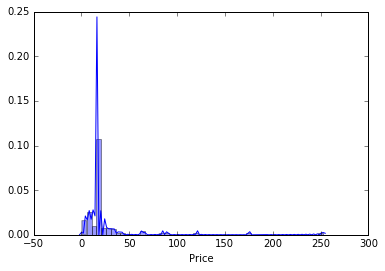

In [245]:
#let's plot it

sns.distplot(newdf['Price'])

In [ ]:
#the above graph shows a right skewed distribution , which suggests that low sales ranked(Frequently baught) items have low prices
# having the 75% products below price 16.08 $.
#total 50% products fall between 13.46 - 15.95 .
#above infrences are based on the taken sample only.

#may be for category Movies & TV people tend to buy less expansive options.(one time watch may be) :)







